In [11]:
import matplotlib.pyplot as plt
import numpy as np
from dezero import Model
from dezero import optimizers
import dezero.functions as F
import dezero.layers as L
from dezerogym.gridworld import GridWorld

def argmax(xs):
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]
    if len(idxes) == 1:
        return idxes[0]
    elif len(idxes) == 0:
        return np.random.choice(len(xs))

    selected = np.random.choice(idxes)
    return selected


def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = argmax(qs)  # OR np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs


def plot_total_reward(reward_history):
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(range(len(reward_history)), reward_history)
    plt.show()




In [12]:
def one_hot(state):
    HEIGHT, WIDTH = 3, 4
    vec = np.zeros(HEIGHT * WIDTH, dtype=np.float32)

    y, x = state
    idx = WIDTH * y + x
    vec[idx] = 1.0

    return vec[np.newaxis, :]

state = (2, 0)
x = one_hot(state)

print(x.shape)
print(x)

(1, 12)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [13]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class QNet(Model):
    def __init__(self):
        super().__init__()
        self.l1 = L.Linear(100)
        self.l2 = L.Linear(4)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        return x
    
qnet = QNet()

state = (2, 0)
state = one_hot(state)

qs = qnet(state)
print(qs.shape)

(1, 4)


In [23]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.lr = 0.01
        self.epsilon = 0.1
        self.action_size = 4

        self.qnet = QNet()
        self.optimizer = optimizers.SGD(self.lr)
        self.optimizer.setup(self.qnet)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = self.qnet(state)
            return qs.data.argmax()
        
    def update(self, state, action, reward, next_state, done):
        # if done:
        #     next_q = np.zeros(1)
        # else:
        #     next_qs = self.qnet(next_state)
        #     next_q = next_qs.max(axis=1)
        #     next_q.unchain()
        
        done = int(done)
        next_qs = self.qnet(next_state)
        next_q = next_qs.max(axis=1)
        next_q.unchain()

        # target = self.gamma * next_q + reward
        target = (1 - done) * self.gamma * next_q + reward

        qs = self.qnet(state)
        q = qs[:, action]

        loss = F.mean_squared_error(target, q)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

        return loss.data


In [26]:
env = GridWorld()
agent = QLearningAgent()

episodes = 10000
loss_history = []

for episode in range(episodes):
    state = env.reset()
    state = one_hot(state)
    total_loss, cnt = 0, 0
    done = False

    while not done:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        next_state = one_hot(next_state)

        loss = agent.update(state, action, reward, next_state, done)
        total_loss += loss
        cnt += 1
        state = next_state

    average_loss = total_loss / cnt
    loss_history.append(average_loss)

plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

Q = {}
for state in env.states():
    for action in env.action_space:
        q = agent.qnet(one_hot(state))[:, action]
        Q[state, action] = float(q.data)
env.render_q(Q)

/var/folders/zz/zyxvpxvq6csfxvn_n000cr8m003625/T/ipykernel_3729/3577325236.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Q[state, action] = float(q.data)


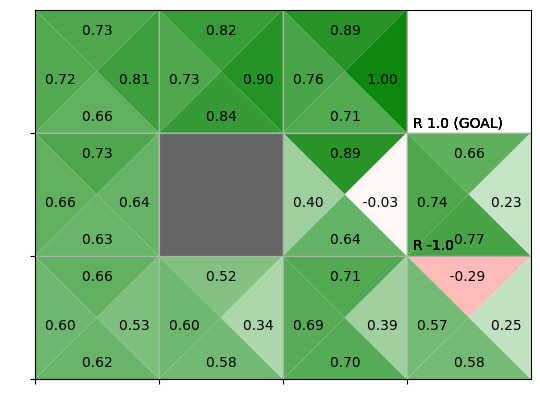

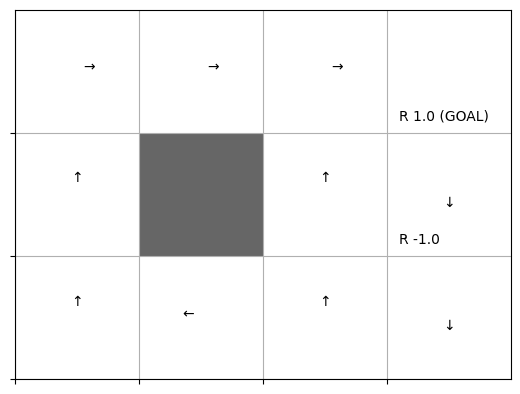